# Label Generation
We use "Kmeans Analysis with uncorrelated features" for label generation.

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import entropy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict
from scipy.stats.stats import pearsonr
from copy import deepcopy
from IPython.display import display, Markdown, Latex
from sklearn.decomposition import PCA
import warnings
import itertools
import operator
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
warnings.filterwarnings('ignore')

img = 'plots/figure_{}.png'
dataFolder = '../../data/{}'

In [2]:
def load_dataset():
    dataset = pd.read_csv(dataFolder.format('customer_behavior_wo_noise.csv'))
    dataset = dataset.set_index('CustomerID')
    return dataset

def visualize_in_2d(df, kmeans_obj):
    pca = PCA(n_components=2)
    x_pc = pca.fit_transform(df)
    pca_df = pd.DataFrame(data=x_pc, columns=['pc1', 'pc2'])
    pca_df['labels'] = kmeans_obj.labels_
    centroids = pca.transform(kmeans_obj.cluster_centers_)
    centroids_df = pd.DataFrame(data=centroids, columns=['pc1', 'pc2'])
    
    plt.figure()
    plt.title("Visualization of the principal components")
    plt.scatter(pca_df['pc1'], pca_df['pc2'], s=10)
    plt.show()
    
    plt.figure()
    plt.title("KMeans clusters")
    plt.scatter(pca_df['pc1'], pca_df['pc2'], c=pca_df['labels'], s=20)
    plt.scatter(centroids_df['pc1'], centroids_df['pc2'], s=200, marker='*', c='cyan')
    plt.show()

In [3]:
dataset = load_dataset()
dataset

,Money Spent Entropy,Mean Qta Q1,Mean Money Spent Q1,Mean Qta Q2,Mean Money Spent Q2,Mean Qta Q3,Mean Money Spent Q3,Distinct Products,Mean Days btw Purchases,Min Days btw Purchases,Max Days btw Purchases,Max Products In Basket,Min Products In Basket,Mean Products In Basket,Total Products,Distinct Baskets
CustomerID,,,,,,,,,,,,,,,,
12347,4.518601,7.294118,13.050588,9.000000,14.376154,8.923077,13.043077,66,167.83333,64,265,26,4,14.142857,916,7
12349,3.535598,0.000000,0.000000,0.000000,0.000000,8.800000,14.474667,35,697.00000,697,697,35,35,35.000000,328,1
12350,2.664537,11.714286,13.728571,0.000000,0.000000,0.000000,0.000000,15,697.00000,697,697,15,15,15.000000,172,1
12352,3.622310,10.416667,14.894167,0.000000,0.000000,8.250000,15.512500,31,85.50000,5,201,8,1,5.428571,365,7
12353,0.673012,0.000000,0.000000,7.000000,14.650000,0.000000,0.000000,2,697.00000,697,697,2,2,2.000000,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18278,1.584802,0.000000,0.000000,0.000000,0.000000,9.333333,13.400000,5,697.00000,697,697,5,5,5.000000,46,1
18280,1.775971,0.000000,0.000000,5.200000,16.140000,0.000000,0.000000,6,697.00000,697,697,6,6,6.000000,34,1
18281,0.692627,0.000000,0.000000,0.000000,0.000000,8.000000,15.900000,2,697.00000,697,697,2,2,2.000000,16,1


In [4]:
selected_features = ['Money Spent Entropy','Mean Money Spent Q1','Mean Money Spent Q2','Mean Money Spent Q3','Mean Qta Q1','Mean Qta Q2','Mean Qta Q3','Mean Days btw Purchases','Mean Products In Basket']
dataset = dataset[selected_features]
dataset['Mean Qta'] = dataset['Mean Qta Q1'] + dataset['Mean Qta Q2'] + dataset['Mean Qta Q3']
dataset['Mean Money Spent'] = dataset['Mean Money Spent Q1'] + dataset['Mean Money Spent Q2'] + dataset['Mean Money Spent Q3']
del dataset['Mean Qta Q1'] 
del dataset['Mean Qta Q2']
del dataset['Mean Qta Q3']
del dataset['Mean Money Spent Q1']
del dataset['Mean Money Spent Q2']
del dataset['Mean Money Spent Q3']
dataset

,Money Spent Entropy,Mean Days btw Purchases,Mean Products In Basket,Mean Qta,Mean Money Spent
CustomerID,,,,,
12347,4.518601,167.83333,14.142857,25.217195,40.469819
12349,3.535598,697.00000,35.000000,8.800000,14.474667
12350,2.664537,697.00000,15.000000,11.714286,13.728571
12352,3.622310,85.50000,5.428571,18.666667,30.406667
12353,0.673012,697.00000,2.000000,7.000000,14.650000
...,...,...,...,...,...
18278,1.584802,697.00000,5.000000,9.333333,13.400000
18280,1.775971,697.00000,6.000000,5.200000,16.140000
18281,0.692627,697.00000,2.000000,8.000000,15.900000


<AxesSubplot:>

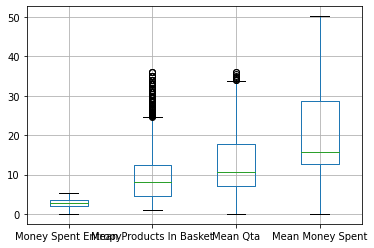

In [5]:
dataset[['Money Spent Entropy','Mean Products In Basket','Mean Qta','Mean Money Spent']].boxplot()

In [6]:
dataset.describe()

,Money Spent Entropy,Mean Days btw Purchases,Mean Products In Basket,Mean Qta,Mean Money Spent
count,3724.000000,3724.000000,3724.000000,3724.000000,3724.000000
mean,2.692028,349.900471,9.308216,12.647245,20.418028
std,1.171500,291.174066,6.474993,7.801318,11.722251
min,0.000000,1.000000,1.000000,0.000000,0.000000
25%,1.925683,89.883334,4.500000,7.200000,12.600000
50%,2.719919,175.666665,8.000000,10.666667,15.801250
75%,3.549322,697.000000,12.500000,17.859722,28.794643
max,5.336665,697.000000,36.000000,36.000000,50.190000


In [7]:
dataset['Customer Type'] = ''
high_money_spent = dataset['Mean Money Spent'].describe()[6]
low_money_spent = dataset['Mean Money Spent'].describe()[4]
high_entropy = dataset['Money Spent Entropy'].describe()[6]
low_entropy = dataset['Money Spent Entropy'].describe()[4]
high_qta = dataset['Mean Qta'].describe()[6]
low_qta = dataset['Mean Qta'].describe()[4]
high_prods = dataset['Mean Products In Basket'].describe()[6]
low_prods = dataset['Mean Products In Basket'].describe()[4]

for idx, (_, row) in enumerate(dataset.iterrows()):
    if (row['Mean Money Spent'] >= high_money_spent) and ((row['Mean Qta'] >= high_qta) or (row['Mean Products In Basket'] >= high_prods)):
        dataset['Customer Type'].iloc[idx] = 'high-spending'
    elif (row['Mean Money Spent'] <= low_money_spent) and ((row['Mean Qta'] >= low_qta) or (row['Mean Products In Basket'] >= low_prods)):
        dataset['Customer Type'].iloc[idx] = 'low-spending'
    else:
        dataset['Customer Type'].iloc[idx] = 'medium-spending'
dataset

,Money Spent Entropy,Mean Days btw Purchases,Mean Products In Basket,Mean Qta,Mean Money Spent,Customer Type
CustomerID,,,,,,
12347,4.518601,167.83333,14.142857,25.217195,40.469819,high-spending
12349,3.535598,697.00000,35.000000,8.800000,14.474667,medium-spending
12350,2.664537,697.00000,15.000000,11.714286,13.728571,medium-spending
12352,3.622310,85.50000,5.428571,18.666667,30.406667,high-spending
12353,0.673012,697.00000,2.000000,7.000000,14.650000,medium-spending
...,...,...,...,...,...,...
18278,1.584802,697.00000,5.000000,9.333333,13.400000,medium-spending
18280,1.775971,697.00000,6.000000,5.200000,16.140000,medium-spending
18281,0.692627,697.00000,2.000000,8.000000,15.900000,medium-spending


In [8]:
dataset.to_csv(dataFolder.format('customer_behavior_labeled.csv'))

In [9]:
dataset['n of examples'] = 1
n = dataset.groupby(['Customer Type']).count()
display(n[['n of examples']])
del dataset['n of examples']

,n of examples
Customer Type,
high-spending,772
low-spending,681
medium-spending,2271
